## Clustering of cell image embeddings

Cells were treated with various compounds, and images were acquired post treatment. We trained a CNN classifier using the Inception v3 architecture to recognize the mode of action (MoA) of the compounds from the cell images. 
We then took this model, removed the last fully connected layer which does the classification, and generated the embeddings of the cell images. Our objective is to explore these embeddings, in order to find potential information on the compound structures, which would indicate that there is a possibility to map compound structure from cell images, and therefore potential to create compound generative models. 

As a first step, we will perform a principal component analysis (PCA) and apply whitening which will help removing the noise from the picture embeddings. We will determine the appropriate number of principal components to keep by aiming at a minimum explained variance of 95% of the original dataset variance.

We will then apply clustering on the principal components and on the original embedding vectors, to explore the embeddings space. 

In [30]:
#We first import the required packages
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
#we load the dataframe with embeddings
path = 'embedding_datasets/'
file_name = 'embeddings_l2l_MoA_only.csv'
df = pd.read_csv(path + file_name)

df.head()

,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,...,V2038,V2039,V2040,V2041,V2042,V2043,V2044,V2045,V2046,V2047
0,2,113,Week2_180607_D10_s1_w13459A84F-B9BB-4FB2-B58E-...,Week2/Week2_24121,Week2_180607_D10_s1_w2D35FB8FC-0085-4F4D-B14A-...,Week2/Week2_24121,Week2_180607_D10_s1_w440EA0925-FF71-447F-B395-...,Week2/Week2_24121,Week2_24121,D10,...,0.0,179.425415,237.771286,268.848145,18.922123,301.925629,958.774719,702.290161,0.000000,578.043396
1,2,114,Week2_180607_D10_s2_w111F1FA1E-8B45-451D-9C50-...,Week2/Week2_24121,Week2_180607_D10_s2_w277BE8611-E2E6-456E-838C-...,Week2/Week2_24121,Week2_180607_D10_s2_w433B4BF8D-9087-401F-89B1-...,Week2/Week2_24121,Week2_24121,D10,...,0.0,194.362671,243.139114,289.954834,12.773600,296.099213,936.660278,704.475891,0.000000,558.482239
2,2,115,Week2_180607_D10_s3_w13C4CF98E-5824-43A6-A319-...,Week2/Week2_24121,Week2_180607_D10_s3_w2D8C8A48C-6EAF-463F-A673-...,Week2/Week2_24121,Week2_180607_D10_s3_w4E03CCDE6-86D5-4F10-9B54-...,Week2/Week2_24121,Week2_24121,D10,...,0.0,233.560394,196.052811,349.675690,11.262443,322.245850,1003.410828,775.270569,0.028846,692.620544
3,2,116,Week2_180607_D10_s4_w1E4144E18-06FF-4789-8F9F-...,Week2/Week2_24121,Week2_180607_D10_s4_w25BD84D0B-672D-4292-87B7-...,Week2/Week2_24121,Week2_180607_D10_s4_w4A0FA5EEA-D0F6-4857-9C81-...,Week2/Week2_24121,Week2_24121,D10,...,0.0,191.231522,225.091232,276.203430,18.310738,300.330383,962.777527,729.738281,0.000000,610.617615
4,2,353,Week2_180607_D10_s1_w199106068-CEA7-4BAB-83EA-...,Week2/Week2_24141,Week2_180607_D10_s1_w20787BC73-DFAE-40D7-80BA-...,Week2/Week2_24141,Week2_180607_D10_s1_w4E09AB7C1-BAF1-4FFE-BFC7-...,Week2/Week2_24141,Week2_24141,D10,...,0.0,165.704620,244.550369,329.414825,15.526624,297.618347,988.768860,735.684631,0.000399,613.368652


In [17]:
#we now check which columns indices contain embeddings. Columns containing embedding values start with 'V0'
print('embeddings start at column index {}'.format(df.columns.get_loc('V0')))
df.columns[5:]

embeddings start at column index 15


Index(['Image_PathName_Tubulin', 'Image_FileName_Actin',
       'Image_PathName_Actin', 'Image_Metadata_Plate_DAPI',
       'Image_Metadata_Well_DAPI', 'Replicate', 'Image_Metadata_Compound',
       'Image_Metadata_Concentration', 'Image_Metadata_MoA',
       'Image_Metadata_SMILES',
       ...
       'V2038', 'V2039', 'V2040', 'V2041', 'V2042', 'V2043', 'V2044', 'V2045',
       'V2046', 'V2047'],
      dtype='object', length=2058)

#### 1) Dimensionality reduction

The image embeddings consist in more than 2000 features. We want to apply dimensionality reduction to both reduce the number of features, and to apply whitening which will help removing the noise from the picture embeddings. We will apply PCA with whitening, and keep the 64 to 256 first principal components. To ensure we remove the noise from the pictures, we will fit the PCA on the pictures obtained with DMSO only (Negative control = no MoA), and then transform the whole dataset.

In [21]:
#first we select the features that are important (i.e. the embeddings themselves) in the dataframe
data = df.iloc[:, 15:]

#then we normalize the data
sc = StandardScaler()
data = sc.fit_transform(data)

#we transform back the np.array into a pd.DataFrame, and add the compound column to be able to select those which correspond to DMSO
df_pca = pd.DataFrame(data)
df_pca['compound'] = df.Image_Metadata_Compound
df_pca['moa'] = df.Image_Metadata_MoA
df_pca

#now we select only the ones corresponding to DMSO
df_dmso = df_pca[df_pca.compound == 'DMSO']

#and we use it to fit the PCA, either with the first 64, 128, or 256 first principal components
pca_list = []
pc_list = [32, 64, 128, 256]
for n in pc_list:
    print('fitting PCA with {} principal components'.format(n))
    pca = PCA(n_components=n, whiten = True)
    pca.fit(df_dmso.iloc[:, :-2])
    pca_list.append(pca)


#and we transform the three datasets into a pd.DataFrame again, and append the compounds column
df_pca_list = []
i = 0
for pca in pca_list:
    print('Transforming dataframe with {}-components PCA'.format(pc_list[i]))
    df_ = pd.DataFrame(pca.transform(data))
    df_['compound'] = df.Image_Metadata_Compound
    df_['moa'] = df.Image_Metadata_MoA
    df_pca_list.append(df_)
    i += 1


doing PCA with 32 principal components
doing PCA with 64 principal components
doing PCA with 128 principal components
doing PCA with 256 principal components
Transforming dataframe with 32-components PCA
Transforming dataframe with 64-components PCA
Transforming dataframe with 128-components PCA
Transforming dataframe with 256-components PCA


Let's now have a look at the cumulated explained variance ratio of each pca object we've created. We will plot the cumulated explained variance ratio of the four pca (with 32, 64, 182 and 256 first components respectively) as bar chart.

Text(0.5, 1.0, 'proportion of explained variance\nversus number of principal components')

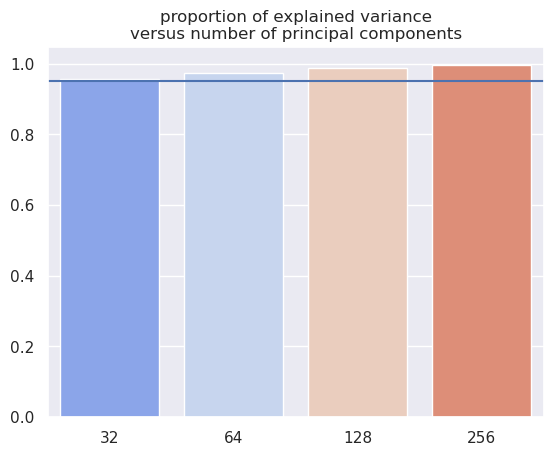

In [23]:
sns.set()
sns.barplot(x = [32, 64, 128, 256], y = [pca_list[n].explained_variance_ratio_.sum() for n in range(4)], palette="coolwarm")
plt.axhline(y = 0.95) #we add a horizontal line at .95% so better visualize which pca reach 95% of explained variance
plt.title('proportion of explained variance\nversus number of principal components')


It seems that the 32 first principal components are sufficient to explain 95% of the original embeddings variance. We will therefore proceed with the 32 PCs-PCA. To avoid re-computing the PCAs, we will export the dataframes with the 4 PCAs as csv.

In [26]:
for idx in range(4):
    #we select the DataFrame with the required pcs
    df_pc = df_pca_list[idx].iloc[:, :-2]

    #we add the columns with Metadata to the pcs DataFrame
    df_pc[['Metadata_PlateNumber', 'Metadata_ID', 'Metadata_TableNumber',
        'Metadata_ImageNumber', 'Metadata_Replicate', 'Metadata_Compound',
        'Metadata_Concentration', 'Metadata_SMILES', 'Metadata_MoA']] = df.iloc[:, :9]

    #and we export it as .csv and pickle
    df_pc.to_csv('csv_files/df_{}_{}pc.csv'.format(file_name.split('_')[1], pc_list[idx]))
   

#### Clustering of embeddings
We will now attempt to cluster the embeddings. The objective is to explore the similarity of embeddings, and compare it to the similarity of chemical structure of compounds used to obtai them.

Based on the qualitative inquiry we performed during Milestone 2, centroid-based clustering techniques are the ones making the most sense for clustering of such a dataset. There is no underlying tree structure between MoAs, which excludes hierarchical clustering. Distribution-based clustering was also not recommended, as it is difficult to estimate if an underlying distribution is present over that many features. We will therefore rely on Kmeans clustering.

We will first create a function that screens over the different hyperparameters of the Kmeans algorithm, in order to find the optimal clustering that overlaps the most with known MoAs.

First, we will determine the range of number of clusters that seems to make sense investigating. We will start with one cluster per known MoA, and screen up to 2x the number of known MoAs (this is a bit arbitrary, but we need an upper limit, and the elbow and silouhette analysis will tell us later if our upper limit was too low).

In [27]:
n_comp =  len(df.Image_Metadata_MoA.unique())
print('there are {} unique MoA '.format(n_comp))


there are 13 unique MoA 


In [33]:
def scout_kmeans(df, col_idx, n_cluster, init , max_iter , save_df, random_state = 0):
    """Scouts Kmeans and stores the results of each trial in a dataframe that is returned by the function.
    The dataframe contains the Kmeans paramters as well as the percentage of overlap between mode of action and 
    cluster found
    Arguments:
        - df: the dataframe that contains the embedding data
        - col_idx: the index of the column where the embeddings start. 15 in the original dataframe
        - n_cluster: list. The values to be tested for hyperparameter n_cluster
        - init: list. The values to be tested for hyperparameter init
        - max_iter: list. The values to be tested for hyperparameter max_iter
        - save_df. Boolean. If true, saves df including cluster values for each screened set of parameters as CSV
    Returns:
        - summary_df: pd.DataFrame object. Contains the combinations of kmeans hyperparameters tested and 
          the resulting overlap between clusters and MoA"""
    
    #get the values of interest from the df
    matrix = df.iloc[:, col_idx:].values
    
    #create 3 lists to store the combination of hyperparameters
    cluster_list = []
    init_list = []
    max_iter_list = []

    #create 2 list to store the inertia and silouhette scores
    inertia_list = []
    silouhette_list = []    

    for cluster in n_cluster:
        for i in init:
            for iter_ in max_iter:
                print('testing {} clusters, {} inits, {} max_iter'.format(cluster, i, iter_))
                
                #update the lists
                cluster_list.append(cluster)
                init_list.append(i)
                max_iter_list.append(iter_)
                
                #create the kmeans object
                km = KMeans(n_clusters = cluster, init = i, max_iter = iter_, random_state = random_state)
                km.fit(matrix)
                labels = km.labels_
                
                #update df with labels
                df_copy = df.copy()
                df_copy['cluster'] = labels
                
                #get the inertia score
                inertia_list.append(km.inertia_)

                #get the silouhette score
                silouhette_list.append(silhouette_score(matrix, km.labels_))

                #save the df
                if save_df:
                    df_copy.to_csv('csv_files/df_clusters_nclusters{}_init{}_maxiter{}_.csv'.format(cluster, i , iter_))


                    
    #create a DataFrame to store kmeans hyperparameters               
    summary_df = pd.DataFrame({'n_cluster': cluster_list,
                               'init' : init_list,
                               'max_iter': max_iter_list,
                               'inertia': inertia_list,
                               'silhouette': silouhette_list})    


                   
    return summary_df

screen_kmeans_df = scout_kmeans(df, 
                                15,
                               [i for i in range(13, 26)],
                               ['k-means++', 'random'], 
                               [300], 
                               save_df = True,
                               random_state = 0)

testing 13 clusters, k-means++ inits, 300 max_iter
